In [3]:
import branca
import branca.colormap as cm
import pandas as pd  # for requirements: install fastparquet as well
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import folium
from scipy.spatial import Voronoi
from math import floor, dist  # not needed in requirements
from tqdm import tqdm

# FUNCTIONS

In [4]:
def assign_georank(enb_df, src_id, precision=1000):
    cells = np.array(enb_df[['LAT','LON']])
    centroid = np.array(enb_df[['LAT','LON']].loc[enb_df['LocInfo']==src_id]) 
    distances = np.linalg.norm(cells-centroid, axis=1) * precision   # normalized distances to centroid, between 0 and 100
    enb_df['Georank'] = [floor(d) for d in distances] 
    return enb_df

In [5]:
def compute_distance(data):
    dist_ser = pd.Series()
    for idx,row in data.iterrows():
        dist_ser[idx] = max(0.1, dist((row.srcLAT,row.srcLON), (row.dstLAT,row.dstLON))*10000)
    data['Distance'] = dist_ser
    return data

def join_ranks(data, enb_df):
    data = data.join(enb_df[['LocInfo','Georank']].set_index('LocInfo'), on='srcLocInfo')
    data.rename(columns={'Georank':'srcRank'}, inplace=True)
    data = data.join(enb_df[['LocInfo','Georank']].set_index('LocInfo'), on='dstLocInfo')
    data.rename(columns={'Georank':'dstRank'}, inplace=True)
    return data

def compute_weight(data, method='inverse', absolute=False, enb_df=None):
    if method == 'inverse':
        data['Weight'] = 1/(data['nbHO15'])  
        
    elif method == 'prop':
        ho_max, ho_min = data['nbHO15'].max(), data['nbHO15'].min()
        data['Weight'] = (ho_max - data.nbHO15)/(ho_max-ho_min)
        
    elif method == 'distance':
        if 'Distance' not in data.columns:
            data = compute_distance(data)
        data['Weight'] = data.Distance / data.nbHO15
        
    elif method == 'rank':
        if 'srcRank' not in data.columns:
            data = join_ranks(data, enb_df)
        ser = pd.Series()
        if absolute:
            for idx,row in data.iterrows():
                ser[idx] = max(1, abs(row.srcRank - row.dstRank)) / row.nbHO15
        else:
            for idx,row in data.iterrows():   
                ser[idx] = max(1, row.srcRank - row.dstRank +1) / row.nbHO15
        data['Weight'] = ser
        
    elif method == 'rank-dist':
        if 'srcRank' not in data.columns:
            data = join_ranks(data, enb_df)
        if 'Distance' not in data.columns:
            data = compute_distance(data)
        ser = pd.Series()
        if absolute:
            for idx,row in data.iterrows():
                ser[idx] = max(1, abs(row.srcRank - row.dstRank)) / row.nbHO15
        else:
            for idx,row in data.iterrows():
                ser[idx] = max(1, row.srcRank - row.dstRank +1) / row.nbHO15
        data['Weight'] = ser * data.Distance
        
    elif method == 'log':
        ho_max = data['nbHO15'].max()
        data['Weight'] = np.log(ho_max) - np.log(data.nbHO15)
        
    else:
        raise ValueError('Invalid method. Choose between inverse, prop, distance, rank, rank-dist, or log.')
    return data

In [6]:
def compute_path_ho(data, path):
    path_ho = 0
    for i in range(len(path)-1):
        arc_ho = data.loc[(data['srcLocInfo']==path[i]) & (data['dstLocInfo']==path[i+1])]['nbHO15'].iloc[0]
        arc_weight = data.loc[(data['srcLocInfo']==path[i]) & (data['dstLocInfo']==path[i+1])]['Weight'].iloc[0]
        #print('Number of handovers between', path[i], 'and', path[i+1],': ', arc_ho, '\tWeight: ', arc_weight)
        path_ho += arc_ho
    return int(path_ho)

def update_graph(graph, path, method='half'):
    if method == 'half':
        for i in range(len(path)-1):
            src, dst = path[i], path[i+1]
            weight = graph[src][dst]['Weight']
            graph[src][dst]['Weight'] = weight*2
            #print('Previous weight:', weight, '\tNew weight:', graph[src][dst]['Weight']) 
    else:
        raise ValueError('Invalid method. Choose between half or min.')
    return graph

In [7]:
def create_map():
    map = folium.Map([45.73303, 4.82297], tiles="OpenStreetMap", zoom_start=13)
    print('Creating base station map...')
    return map

def add_stations(map, df, type='ho', name='4G stations'):
    print('Adding '+name+' layer')
    fg = folium.FeatureGroup(name=name) # Name as it will appear in Layer control
    if type=='ho':
        enb_ids = df.srcLocInfo.unique()
        for id in enb_ids:
            enb_data = df.loc[df['srcLocInfo']==id]
            fg.add_child(folium.Marker(
                location=[enb_data['srcLAT'].iloc[-1], enb_data['srcLON'].iloc[-1]],
                popup=enb_data['srcLocInfo'].iloc[-1],
            ))
    if type=='enb':
        enb_ids = df.LocInfo.tolist()
        for id in enb_ids:
            enb_data = df.loc[df['LocInfo']==id]
            fg.add_child(folium.Marker(
                location=[enb_data['LAT'].iloc[-1], enb_data['LON'].iloc[-1]],
                popup=enb_data['LocInfo'].iloc[-1],
            ))
    map.add_child(fg)
    
def add_stations_by_centrality(map, df, name='4G stations'):
    print('Adding '+name+' layer...')
    fg = folium.FeatureGroup(name=name) # Name as it will appear in Layer control
    enb_color = {0:'blue', 0.007:'green', 0.026:'yellow', 0.05:'orange', 0.5:'red'}
    for idx,row in df.iterrows():
        ec = [v for k,v in enb_color.items() if row['BC'] <= k]
        fg.add_child(folium.CircleMarker(
            location=[row['LAT'], row['LON']],
            popup=row['LocInfo'],
            tooltip='Centrality: '+str(row['BC']),
            color='black',
            weight=1,
            fill=True,
            fill_color=ec[0],
            fill_opacity=0.9,
            radius=10
        ))
    map.add_child(fg)
    
def close_map(map, filename):
    folium.LayerControl().add_to(map)
    map.save('maps\\'+filename)
    print('Closing', filename, 'map.')
    
def add_voronoi(map, points):
    print('Adding Voronoi layer')
    vor = Voronoi(list(zip(points['LAT'].tolist(), points['LON'].tolist())))  # Careful with the inversion!!  
    fg = folium.FeatureGroup(name='Voronoi cells', show=True)
    for enb, reg_idx in enumerate(vor.point_region):
        region = vor.regions[reg_idx]
        if -1 not in region and region != []:
            region_coords = []
            for vertex in region:
                region_coords.append(vor.vertices[vertex])
            fg.add_child(folium.Polygon(
                region_coords,
                color="black",
                weight=1,
                fill_color="darkgray",
                fill_opacity=0.2,
                fill=True,
            ))
    map.add_child(fg)
       
def add_flows(map, data, name='4G Handovers', min_weight=900):
    print('Adding Flow layer', name)
    fg = folium.FeatureGroup(name=name)
    flow_weight = {100000:2, 200000:4, 300000:6, 400000:8, 500000:10}
    flow_color = {2:'blue', 4:'green', 6:'yellow', 8:'orange', 10:'red'}
    for idx, row in data.iterrows():
        if row['nbHO15'] >= min_weight:
            fw = [v for k,v in flow_weight.items() if row['nbHO15'] <= k]
            fg.add_child(folium.PolyLine(
                [(row['srcLAT'], row['srcLON']), (row['dstLAT'], row['dstLON'])],
                color = flow_color[fw[0]],
                weight = fw[0],
                opacity = 0.8,
                tooltip = 'Weight: '+str(row['nbHO15'])
            ))
    map.add_child(fg)
      
def add_path(map, enb_data, path_list, name='Path', color='#AA0000', show_path=True, voronoi=True):
    print('Adding Path layer', name)
    fg = folium.FeatureGroup(name=name)
    if show_path:
        fg.add_child(folium.PolyLine(
            locations=zip(path_list['LAT'].tolist(), path_list['LON'].tolist()),
            color = color,
            opacity = 0.8,
            weight = 5
        ))

    if voronoi:
        vor = Voronoi(list(zip(enb_data['LAT'].tolist(), enb_data['LON'].tolist())))  # Careful with the inversion!!  
        for enb_idx, reg_idx in enumerate(vor.point_region):
            region = vor.regions[reg_idx]
            cell_locinfo = enb_data.LocInfo.iloc[enb_idx]
            if -1 not in region and region != []:
                region_coords = []
                if cell_locinfo in path_list.LocInfo.tolist():
                    for vertex in region:
                        region_coords.append(vor.vertices[vertex])
                    fg.add_child(folium.Polygon(
                        region_coords,
                        color = color,
                        weight=1,
                        fill_color = color,
                        fill_opacity=0.3,
                        fill=True,
                    ))
    map.add_child(fg)
    
def add_gt_path(map, data, name='Path', color='#AA0000'):
    print('Adding Path layer', name)
    fg = folium.FeatureGroup(name=name)
    fg.add_child(folium.PolyLine(
        locations=zip(data['LAT'].tolist(), data['LON'].tolist()),
        color = color,
        opacity = 0.8,
        weight = 5
    ))
    map.add_child(fg)

def add_voronoi_path(map, enb_data, cells_data, name='Cells path', color='green'):
    vor = Voronoi(list(zip(enb_data['LAT'].tolist(), enb_data['LON'].tolist())))  # Careful with the inversion!!  
    fg = folium.FeatureGroup(name=name, show=True)
    for enb_idx, reg_idx in enumerate(vor.point_region):
        region = vor.regions[reg_idx]
        cell_locinfo = enb_data.LocInfo.iloc[enb_idx]
        if -1 not in region and region != []:
            region_coords = []
            if type(cells_data) == list:
                if cell_locinfo in cells_data:
                    for vertex in region:
                        region_coords.append(vor.vertices[vertex])
                    fg.add_child(folium.Polygon(
                        region_coords,
                        color = color,
                        weight=1,
                        fill_color = color,
                        fill_opacity=0.3,
                        fill=True,
                    ))
            else:
                if cell_locinfo in cells_data['LocInfo'].values:
                    for vertex in region:
                        region_coords.append(vor.vertices[vertex])
                    fg.add_child(folium.Polygon(
                        region_coords,
                        color = color,
                        weight=1,
                        fill_color = color,
                        fill_opacity=0.3,
                        fill=True,
                    ))
    map.add_child(fg)

In [8]:
def find_closest_enb(path, enb_df, remove_duplicates=True):
    enb_path = []
    enb_list, enb_coords = enb_df.LocInfo.tolist(), list(zip(enb_df.LON.tolist(), enb_df.LAT.tolist()))
    enb_dict = dict(zip(enb_list, enb_coords))
    for idx,row in path.iterrows():
        point = [row.LON, row.LAT]
        distances = {enb: dist(point, enb_dict[enb]) for enb in enb_list}
        closest_enb = min(distances, key=distances.get)
        enb_path.append(closest_enb)
    if remove_duplicates:
        return list(dict.fromkeys(enb_path)) # remove duplicates while preserving order
    return enb_path

def path_score(path_ref, path_ho, enb_df):
    POS = path_ref # All positive elements
    NEG = enb_df.loc[~enb_df.LocInfo.isin(path_ref)].LocInfo.tolist() # All negative elements
    TP = len(set(path_ho).intersection(POS))     # True positives
    FP = len(set(path_ho).intersection(NEG))     # False positives
    FN = len(set(POS).difference(path_ho))       # False negatives
    precision = TP / (TP + FP)          # How many retrieved elements are relevant?
    recall = TP / (TP + FN)             # How many relevant elements are retrieved?
    f1_score = 2*TP / (2*TP + FP + FN)  # Harmonic mean of precision and recall
    return {'Precision': precision, 'Recall': recall, 'F1_Score': f1_score}

In [9]:
def smooth_path(path, enb_data, interp_coef=3):
    path_df = pd.DataFrame(index=np.arange(0, interp_coef*(len(path)-1), 1), columns=['LocInfo','LAT','LON'])
    path_df = path_df.astype({'LAT':np.float64, 'LON':np.float64})
    for i in range(0, len(path)):
        row = enb_data.loc[enb_data['LocInfo']==path[i]]
        path_df.loc[i*interp_coef, 'LocInfo'] = row['LocInfo'].iloc[0]
        path_df.loc[i*interp_coef, 'LAT'] = row['LAT'].iloc[0]
        path_df.loc[i*interp_coef, 'LON'] = row['LON'].iloc[0]
    # Interpolate coordinates
    path_df['LAT'] = path_df['LAT'].interpolate()
    path_df['LON'] = path_df['LON'].interpolate()
    # Interpolate LocInfos
    enb_list = find_closest_enb(path_df[['LAT','LON']], enb_data, remove_duplicates=False)
    path_df['LocInfo'] = pd.Series(enb_list)
    #path_smooth = path_df.LocInfo.tolist()
    return path_df.drop_duplicates(subset=['LocInfo']) # remove duplicates while preserving order

def flow_count(ho_df, enb_df):
    times = ['NIGHT', 'MORNING', 'DAY', 'EVENING']
    for time in times:
        enb_df['HO_in_'+time], enb_df['HO_out_'+time] = 0, 0
    for idx, row in enb_df.iterrows():
        enb = row['LocInfo']
        for time in times:
            enb_df.loc[idx, 'HO_in_'+time] += ho_df.loc[(ho_df['srcLocInfo']==enb) & (ho_df['Time']==time)].nbHO15.sum()
            enb_df.loc[idx, 'HO_out_'+time] += ho_df.loc[(ho_df['dstLocInfo']==enb) & (ho_df['Time']==time)].nbHO15.sum()

In [10]:
import matplotlib.ticker as ticker

def box_plot(datasets, index, fill_color, hatch_pattern=None):
    x_pos_range = np.arange(len(datasets)) / (len(datasets) - 1)
    x_pos = (x_pos_range * 0.5) + 0.75
    bp = ax.boxplot(
        np.array(datasets[index]), sym='', whis=[0, 100], widths=0.6 / len(datasets),
        labels=list(datasets[0]),
        positions=[x_pos[index] + j * 1 for j in range(len(datasets[index].T))],
        patch_artist=True
    )
    for median in bp['medians']:
        median.set_color('black')
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)
        if hatch_pattern: 
            patch.set(hatch=hatch_pattern)    
    return bp

# GLOBAL VARIABLES

In [18]:
METHOD = 'rank'
ABS = False
NB_PATHS = 1
INTERP_COEF = 10

# CITY-WIDE ANALYSIS
## 1. Import data 

In [25]:
PATH = '..\\Processed_data\\HO_AGG_18-22_WEEKDAY_4G_coords_reduced.snappy.parquet' # For weekday dataset
#PATH = '..\\Processed_data\\HO_AGG_16-17_WEEKEND_4G_coords_reduced.snappy.parquet' # For weekend dataset

agg_df = pd.read_parquet(PATH, engine='fastparquet')
ho_df = agg_df.loc[agg_df.srcLocInfo != agg_df.dstLocInfo]
ho_df

,srcLocInfo,dstLocInfo,nbHO15,Time,srcTechno,srcLON,srcLAT,dstTechno,dstLON,dstLAT
index,,,,,,,,,,
140,8102f8100000994e,8102f81000009973,18,NIGHT,4G,4.818062,45.762236,4G,4.822226,45.763890
141,8102f8100000994e,8102f81000009975,15,NIGHT,4G,4.818062,45.762236,4G,4.832776,45.744997
142,8102f8100000994e,8102f8100000998b,33,NIGHT,4G,4.818062,45.762236,4G,4.849719,45.770282
143,8102f8100000994e,8102f8100000998e,92,NIGHT,4G,4.818062,45.762236,4G,4.826943,45.729725
144,8102f8100000994e,8102f81000009992,103,NIGHT,4G,4.818062,45.762236,4G,4.831664,45.766391
...,...,...,...,...,...,...,...,...,...,...
49276,8102f8100000bad0,8102f81000009995,18,EVENING,4G,4.820179,45.775520,4G,4.844167,45.762782
49277,8102f8100000bad0,8102f810000099b7,38,EVENING,4G,4.820179,45.775520,4G,4.832777,45.772496
49278,8102f8100000bad0,8102f810000099c6,1965,EVENING,4G,4.820179,45.775520,4G,4.829172,45.776392


In [26]:
TOTAL_HO = int(ho_df['nbHO15'].sum())
TOTAL_HO

61837627

In [27]:
PATH_TOPO = '..\\..\\Data_Handover\\TOPO\\Lyon\\part-00000-2f038a97-7faf-46f3-aee2-b73b52bf2cba.snappy.parquet'

enb_df = pd.read_parquet(PATH_TOPO, engine='fastparquet')
enb_df = enb_df.loc[enb_df['LocInfo'].isin(ho_df['srcLocInfo'])].reset_index(drop=True)
enb_df['Score'] = 0 # Nb passages through cell
enb_df

,LocInfo,TECHNO,LON,LAT,Score
0,8102f8100000999d,4G,4.888138,45.738378,0
1,8102f81000009b28,4G,4.819723,45.771390,0
2,8102f8100000997e,4G,4.875561,45.753615,0
3,8102f81000009976,4G,4.846672,45.729169,0
4,8102f81000009959,4G,4.822966,45.733027,0
...,...,...,...,...,...
192,8102f81000009f4a,4G,4.874679,45.764310,0
193,8102f8100000997b,4G,4.880686,45.725675,0
194,8102f8100000ba70,4G,4.867783,45.701943,0
195,8102f8100000996d,4G,4.864943,45.729614,0


In [28]:
flow_count(ho_df, enb_df)
enb_df

,LocInfo,TECHNO,LON,LAT,Score,HO_in_NIGHT,HO_out_NIGHT,HO_in_MORNING,HO_out_MORNING,HO_in_DAY,HO_out_DAY,HO_in_EVENING,HO_out_EVENING
0,8102f8100000999d,4G,4.888138,45.738378,0,2471,2827,75829,79897,90226,91366,52135,53808
1,8102f81000009b28,4G,4.819723,45.771390,0,549,496,52185,53501,59117,59762,39073,38412
2,8102f8100000997e,4G,4.875561,45.753615,0,978,901,39647,36863,42595,40730,35972,34092
3,8102f81000009976,4G,4.846672,45.729169,0,20346,20277,153392,154255,172989,169984,131823,131812
4,8102f81000009959,4G,4.822966,45.733027,0,24369,23664,341154,334822,394698,386634,267332,260238
...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,8102f81000009f4a,4G,4.874679,45.764310,0,53868,52997,271076,257137,330452,316716,274539,264147
193,8102f8100000997b,4G,4.880686,45.725675,0,818,820,34018,33888,41042,41772,26460,27396
194,8102f8100000ba70,4G,4.867783,45.701943,0,764,713,28899,27974,30200,28828,17852,16897
195,8102f8100000996d,4G,4.864943,45.729614,0,5522,5988,114779,117385,140143,143849,99940,103124


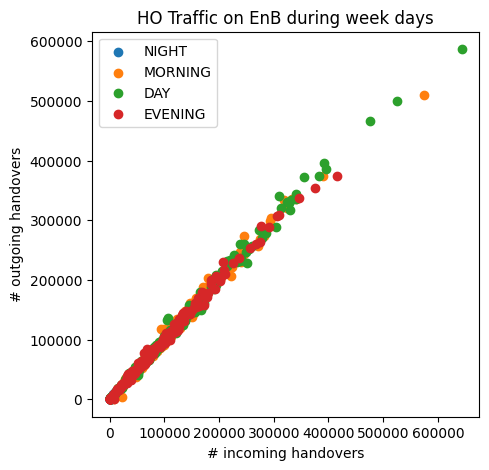

In [29]:
plt.figure(figsize=(5,5))

times = ['NIGHT', 'MORNING', 'DAY', 'EVENING']
for time in times:
    plt.scatter(enb_df['HO_in_'+time], enb_df['HO_out_'+time], label=time)
    #plt.vlines(enb_df.HO_in.mean(), 0, enb_df.HO_out.max())
    #plt.hlines(enb_df.HO_out.mean(), 0, enb_df.HO_in.max())
    
plt.xlabel('# incoming handovers')
plt.ylabel('# outgoing handovers')
plt.title('HO Traffic on EnB during week days')
plt.legend()

C:\Users\arcti\AppData\Local\Temp\ipykernel_9808\2210139216.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(
C:\Users\arcti\AppData\Local\Temp\ipykernel_9808\2210139216.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(
C:\Users\arcti\AppData\Local\Temp\ipykernel_9808\2210139216.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(
C:\Users\arcti\AppData\Local\Temp\ipykernel_9808\2210139216.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  b

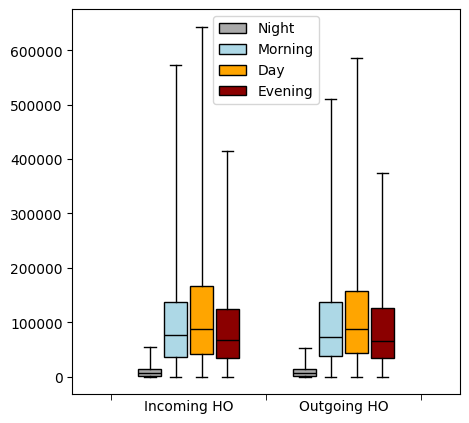

In [30]:
data_night = pd.DataFrame({
    'Incoming HO': enb_df['HO_in_NIGHT'].tolist(),
    'Outgoing HO': enb_df['HO_out_NIGHT'].tolist()
})

data_morning = pd.DataFrame({
    'Incoming HO': enb_df['HO_in_MORNING'].tolist(),
    'Outgoing HO': enb_df['HO_out_MORNING'].tolist()
})

data_day = pd.DataFrame({
    'Incoming HO': enb_df['HO_in_DAY'].tolist(),
    'Outgoing HO': enb_df['HO_out_DAY'].tolist()
})

data_evening = pd.DataFrame({
    'Incoming HO': enb_df['HO_in_EVENING'].tolist(),
    'Outgoing HO': enb_df['HO_out_EVENING'].tolist()
})

datasets = [data_night, data_morning, data_day, data_evening]

fig, ax = plt.subplots(figsize=(5,5))
bp0 = box_plot(datasets, 0, 'darkgray')
bp1 = box_plot(datasets, 1, 'lightblue')
bp2 = box_plot(datasets, 2, 'orange')
bp3 = box_plot(datasets, 3, 'darkred')
plt.xticks(np.arange(len(list(datasets[0]))) + 1)
plt.gca().xaxis.set_minor_locator(ticker.FixedLocator(
    np.array(range(len(list(datasets[0])) + 1)) + 0.5)
)
plt.gca().tick_params(axis='x', which='minor', length=4)
plt.gca().tick_params(axis='x', which='major', length=0)

ax.legend(
    [bp0["boxes"][0], bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], 
    ['Night','Morning','Day','Evening'], 
    loc='best')

In [31]:
# Extract points of interest: EnB with traffic above the average 
POI = {
    'NIGHT': enb_df.loc[(enb_df.HO_in_NIGHT >= enb_df.HO_in_NIGHT.mean()) & (enb_df.HO_out_NIGHT >= enb_df.HO_out_NIGHT.mean())].LocInfo.tolist(),
    'MORNING': enb_df.loc[(enb_df.HO_in_MORNING >= enb_df.HO_in_MORNING.mean()) & (enb_df.HO_out_MORNING >= enb_df.HO_out_MORNING.mean())].LocInfo.tolist(),
    'DAY': enb_df.loc[(enb_df.HO_in_DAY >= enb_df.HO_in_DAY.mean()) & (enb_df.HO_out_DAY >= enb_df.HO_out_DAY.mean())].LocInfo.tolist(),
    'EVENING': enb_df.loc[(enb_df.HO_in_EVENING >= enb_df.HO_in_EVENING.mean()) & (enb_df.HO_out_EVENING >= enb_df.HO_out_EVENING.mean())].LocInfo.tolist()
}

print('Number of POI:')
print([(k,len(v)) for (k,v) in POI.items()])

Number of POI:
[('NIGHT', 72), ('MORNING', 76), ('DAY', 76), ('EVENING', 79)]


In [22]:
lyon = create_map()
for time, df in POI.items():
    add_stations(lyon, enb_df.loc[enb_df.LocInfo.isin(df)], type='enb', name=time)

close_map(lyon, 'lyon_weekday_'+METHOD+'_'+str(ABS)+'_POI.html')
lyon

Creating base station map...
Adding NIGHT layer
Adding MORNING layer
Adding DAY layer
Adding EVENING layer
Closing lyon_weekday_rank_False_POI.html map.


## 2. Loop between all sources and destinations

In [ ]:
#Use NetworkX BC
#Problem with this method: no interpolation, so big jumps over some cells!
enb_list = enb_df_day.LocInfo.tolist()

with tqdm(total=len(enb_list), desc='EnB BC computation') as pbar:
    for enb in enb_list:
        enb_df_day = assign_georank(enb_df_day, src_id=enb)
        ho_df_day = compute_weight(ho_df_day, METHOD, absolute=ABS, enb_df=enb_df_day) 
        G = nx.from_pandas_edgelist(ho_df_day, source='srcLocInfo', target='dstLocInfo', edge_attr='Weight', create_using=nx.DiGraph)
        bc = nx.betweenness_centrality(G, normalized=True, weight='Weight', endpoints=False, seed=None)
        # Increment cell score
        for k,v in bc.items():
            enb_df_day.loc[enb_df_day.LocInfo == k, 'Score'] += v 
        pbar.update(1)

EnB BC computation: 100%|██████████| 197/197 [05:59<00:00,  1.82s/it]


In [41]:
time = 'DAY'

poi = POI[time]
#poi = POI['DAY']
enb_df.Score = 0
print('=====================', time, '=====================\n')
for i in range(len(poi)):
    ENB_SRC = poi[i]
    with tqdm(total=len(poi), desc='Computing paths from '+ENB_SRC+' ('+str(i+1)+'/'+str(len(poi))+')') as pbar:
        for j in range(len(poi)):
            ENB_DST = poi[j]
            #print('Computing path between', ENB_SRC, 'and', ENB_DST, '['+str(i)+'/'+str(len(SRC_LIST))+']')
            enb_df = assign_georank(enb_df, src_id=ENB_SRC)
            time_df = compute_weight(ho_df.loc[ho_df.Time==time], METHOD, absolute=ABS, enb_df=enb_df) # Keep only the relevant time HO
            G = nx.from_pandas_edgelist(time_df, source='srcLocInfo', target='dstLocInfo', edge_attr='Weight', create_using=nx.DiGraph) # NetworkX graph
            sp = nx.shortest_path(G, ENB_SRC, ENB_DST, weight='Weight', method='bellman-ford') # Bellman-Ford is better for directed graphs
            path = smooth_path(sp, enb_df, INTERP_COEF)
            #print('Path length:', len(sp), '\tInterpolated path length:', len(path))
            enb_df.loc[enb_df.LocInfo.isin(path.LocInfo.tolist()), 'Score'] += 1  # Increment EnB score
            pbar.update(1)

===================== DAY =====================



Computing paths from 8102f81000009952 (76/76): 100%|██████████| 76/76 [01:54<00:00,  1.50s/it]


(array([93., 27., 26., 21., 13.,  7.,  0.,  2.,  5.,  3.]),
 array([   0. ,  162.5,  325. ,  487.5,  650. ,  812.5,  975. , 1137.5,
        1300. , 1462.5, 1625. ]),
 <BarContainer object of 10 artists>)

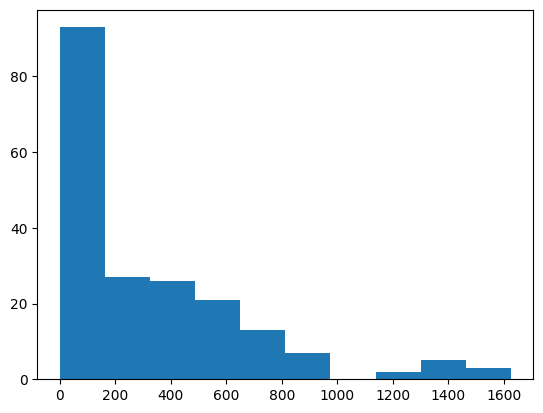

In [42]:
plt.hist(enb_df.Score.tolist())

In [43]:
enb_df

,LocInfo,TECHNO,LON,LAT,Score,HO_in_NIGHT,HO_out_NIGHT,HO_in_MORNING,HO_out_MORNING,HO_in_DAY,HO_out_DAY,HO_in_EVENING,HO_out_EVENING,Georank
0,8102f8100000999d,4G,4.888138,45.738378,0,2471,2827,75829,79897,90226,91366,52135,53808,62
1,8102f81000009b28,4G,4.819723,45.771390,420,549,496,52185,53501,59117,59762,39073,38412,20
2,8102f8100000997e,4G,4.875561,45.753615,0,978,901,39647,36863,42595,40730,35972,34092,48
3,8102f81000009976,4G,4.846672,45.729169,820,20346,20277,153392,154255,172989,169984,131823,131812,30
4,8102f81000009959,4G,4.822966,45.733027,1266,24369,23664,341154,334822,394698,386634,267332,260238,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,8102f81000009f4a,4G,4.874679,45.764310,151,53868,52997,271076,257137,330452,316716,274539,264147,48
193,8102f8100000997b,4G,4.880686,45.725675,174,818,820,34018,33888,41042,41772,26460,27396,59
194,8102f8100000ba70,4G,4.867783,45.701943,0,764,713,28899,27974,30200,28828,17852,16897,64
195,8102f8100000996d,4G,4.864943,45.729614,216,5522,5988,114779,117385,140143,143849,99940,103124,44


In [44]:
enb_df.to_parquet('ENB_SCORE_WEEKDAY_'+time+'.parquet', engine='fastparquet', compression='snappy')

## 3. Folium visualization

In [20]:
def add_voronoi(map, points, colormap, name='Daytime'):
    print('Adding Voronoi layer '+name)
    vor = Voronoi(list(zip(points['LAT'].tolist(), points['LON'].tolist())))  # Careful with the inversion!!  
    fg = folium.FeatureGroup(name='Voronoi cells '+name, show=True)
    for enb, reg_idx in enumerate(vor.point_region):
        region = vor.regions[reg_idx]
        cell_locinfo = points.LocInfo.iloc[enb]
        if -1 not in region and region != []:
            region_coords = []
            for vertex in region:
                region_coords.append(vor.vertices[vertex])
            score = points.loc[points.LocInfo==cell_locinfo, 'Score'].iloc[0]
            fg.add_child(folium.Polygon(
                region_coords,
                color="darkgray",
                weight=1,
                fill_color=colormap(score),
                fill_opacity=0.3,
                fill=True,
                tooltip=score
            ))
    map.add_child(fg)
    map.add_child(colormap)

In [13]:
enb_df = {}
times = ['NIGHT','MORNING','DAY','EVENING']

for t in times:
    df = pd.read_parquet('ENB_SCORE_WEEKDAY_'+t+'.parquet', engine='fastparquet')
    enb_df[t] = df
    
enb_df

{'NIGHT':               LocInfo TECHNO       LON        LAT  Score  HO_in_NIGHT  \
 0    8102f8100000999d     4G  4.888138  45.738378      0         2471   
 1    8102f81000009b28     4G  4.819723  45.771390    285          549   
 2    8102f8100000997e     4G  4.875561  45.753615      0          978   
 3    8102f81000009976     4G  4.846672  45.729169   1303        20346   
 4    8102f81000009959     4G  4.822966  45.733027   1509        24369   
 ..                ...    ...       ...        ...    ...          ...   
 192  8102f81000009f4a     4G  4.874679  45.764310    888        53868   
 193  8102f8100000997b     4G  4.880686  45.725675    364          818   
 194  8102f8100000ba70     4G  4.867783  45.701943      0          764   
 195  8102f8100000996d     4G  4.864943  45.729614    224         5522   
 196  8102f81000009952     4G  4.827545  45.752980    879        34028   
 
      HO_out_NIGHT  HO_in_MORNING  HO_out_MORNING  HO_in_DAY  HO_out_DAY  \
 0            2827       

Text(0, 0.5, 'Centrality score')

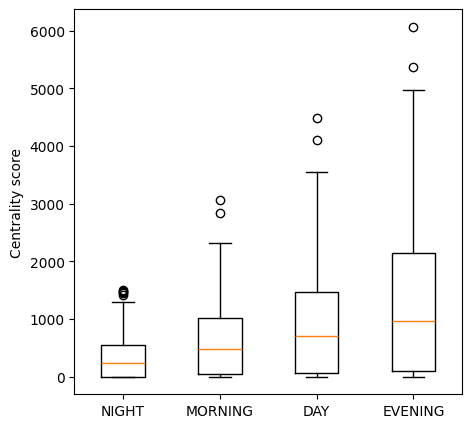

In [24]:
plt.figure(figsize=(5,5))
plt.boxplot([df.Score for df in enb_df.values()], tick_labels=enb_df.keys())
plt.ylabel('Centrality score')

In [22]:
lyon = create_map()
folium.TileLayer('CartoDB Positron').add_to(lyon)
#smin, smax = 0, max([df.Score.max() for df in enb_df.values()])
smin, smax = 0, 5000
colormap = cm.LinearColormap(colors=['lightblue','red'], index=[smin,smax],vmin=smin,vmax=smax)
for t,df in enb_df.items():
    add_voronoi(lyon, df, colormap, name=t)

close_map(lyon, 'lyon_full_NMDE_'+METHOD+'_'+str(ABS)+'.html')
lyon

Creating base station map...
Adding Voronoi layer NIGHT
Adding Voronoi layer MORNING
Adding Voronoi layer DAY
Adding Voronoi layer EVENING
Closing lyon_full_NMDE_rank_False.html map.
